In [1]:
from sensor_network_utils import * 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
flowdata_paths = ['data/dailyflow_v3_1.csv', 'data/dailyflow_v3_2.csv']
df_cleaned, gauges_gdf, flowlines_gdf, usgs_index_df = load_data(
    flowdata_paths,
    'data/gage_12_shpaefile/SWIM_gage_loc_12.shp',
    'data/tx_gulf_flowlines/flowlines.shp',
    'data/gage_12.csv'
)

In [3]:
# Prepare USGS indices
usgs_location, usgs_number, columns_to_keep = prepare_usgs_indices(df_cleaned, usgs_index_df)


In [4]:
# Split data
X_train, X_test = split_data(df_cleaned.values)


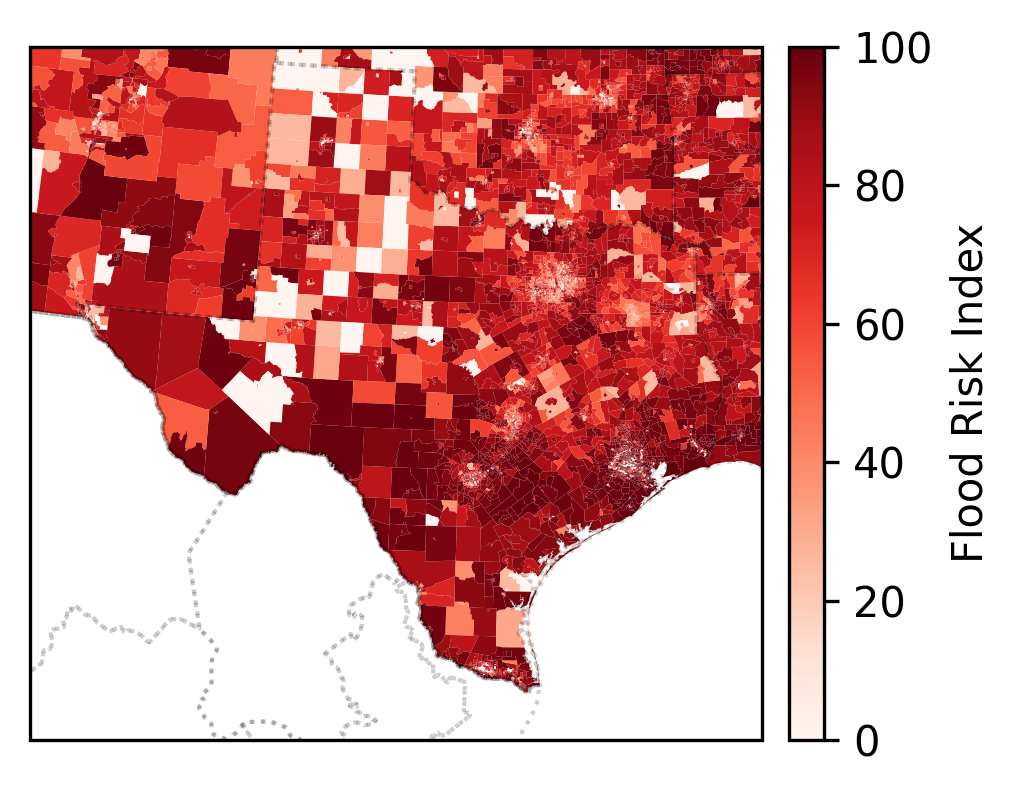

In [5]:
gdb_path = "data/NRI_GDB_CensusTracts/NRI_GDB_CensusTracts.gdb"

fig, ax, flowlines_risk, flood_risk = plot_flood_risk_map(
    gdb_path=gdb_path,
    flowlines_gdf=flowlines_gdf,
    df_cleaned=df_cleaned,
    save_path='flood_risk_map.png'
)

In [6]:
# Get sensor placement 
sensor_location = sensor_placement_qr(X_train, usgs_number)
sensor_location_risk = sensor_placement_qr(X_train, usgs_number, weights = flood_risk)

In [7]:
# Evaluate both configurations
_, recon_opt, _, _, rmse_values_opt, _ = reconstruction_evaluation(X_train, X_test, sensor_location, usgs_number)
_, recon_usgs, _, _, rmse_values_usgs, _ = reconstruction_evaluation(X_train, X_test, usgs_location, usgs_number)
_, recon_risk, _, _, rmse_values_risk, _ = reconstruction_evaluation(X_train, X_test, sensor_location_risk, usgs_number)

In [8]:
# Calculate performance

_, _, nnse_opt = calculate_performance_metrics(X_test, recon_opt)
_, _, nnse_usgs = calculate_performance_metrics(X_test, recon_usgs)
_, _, nnse_risk = calculate_performance_metrics(X_test, recon_risk)
diff_nnse = nnse_opt - nnse_risk

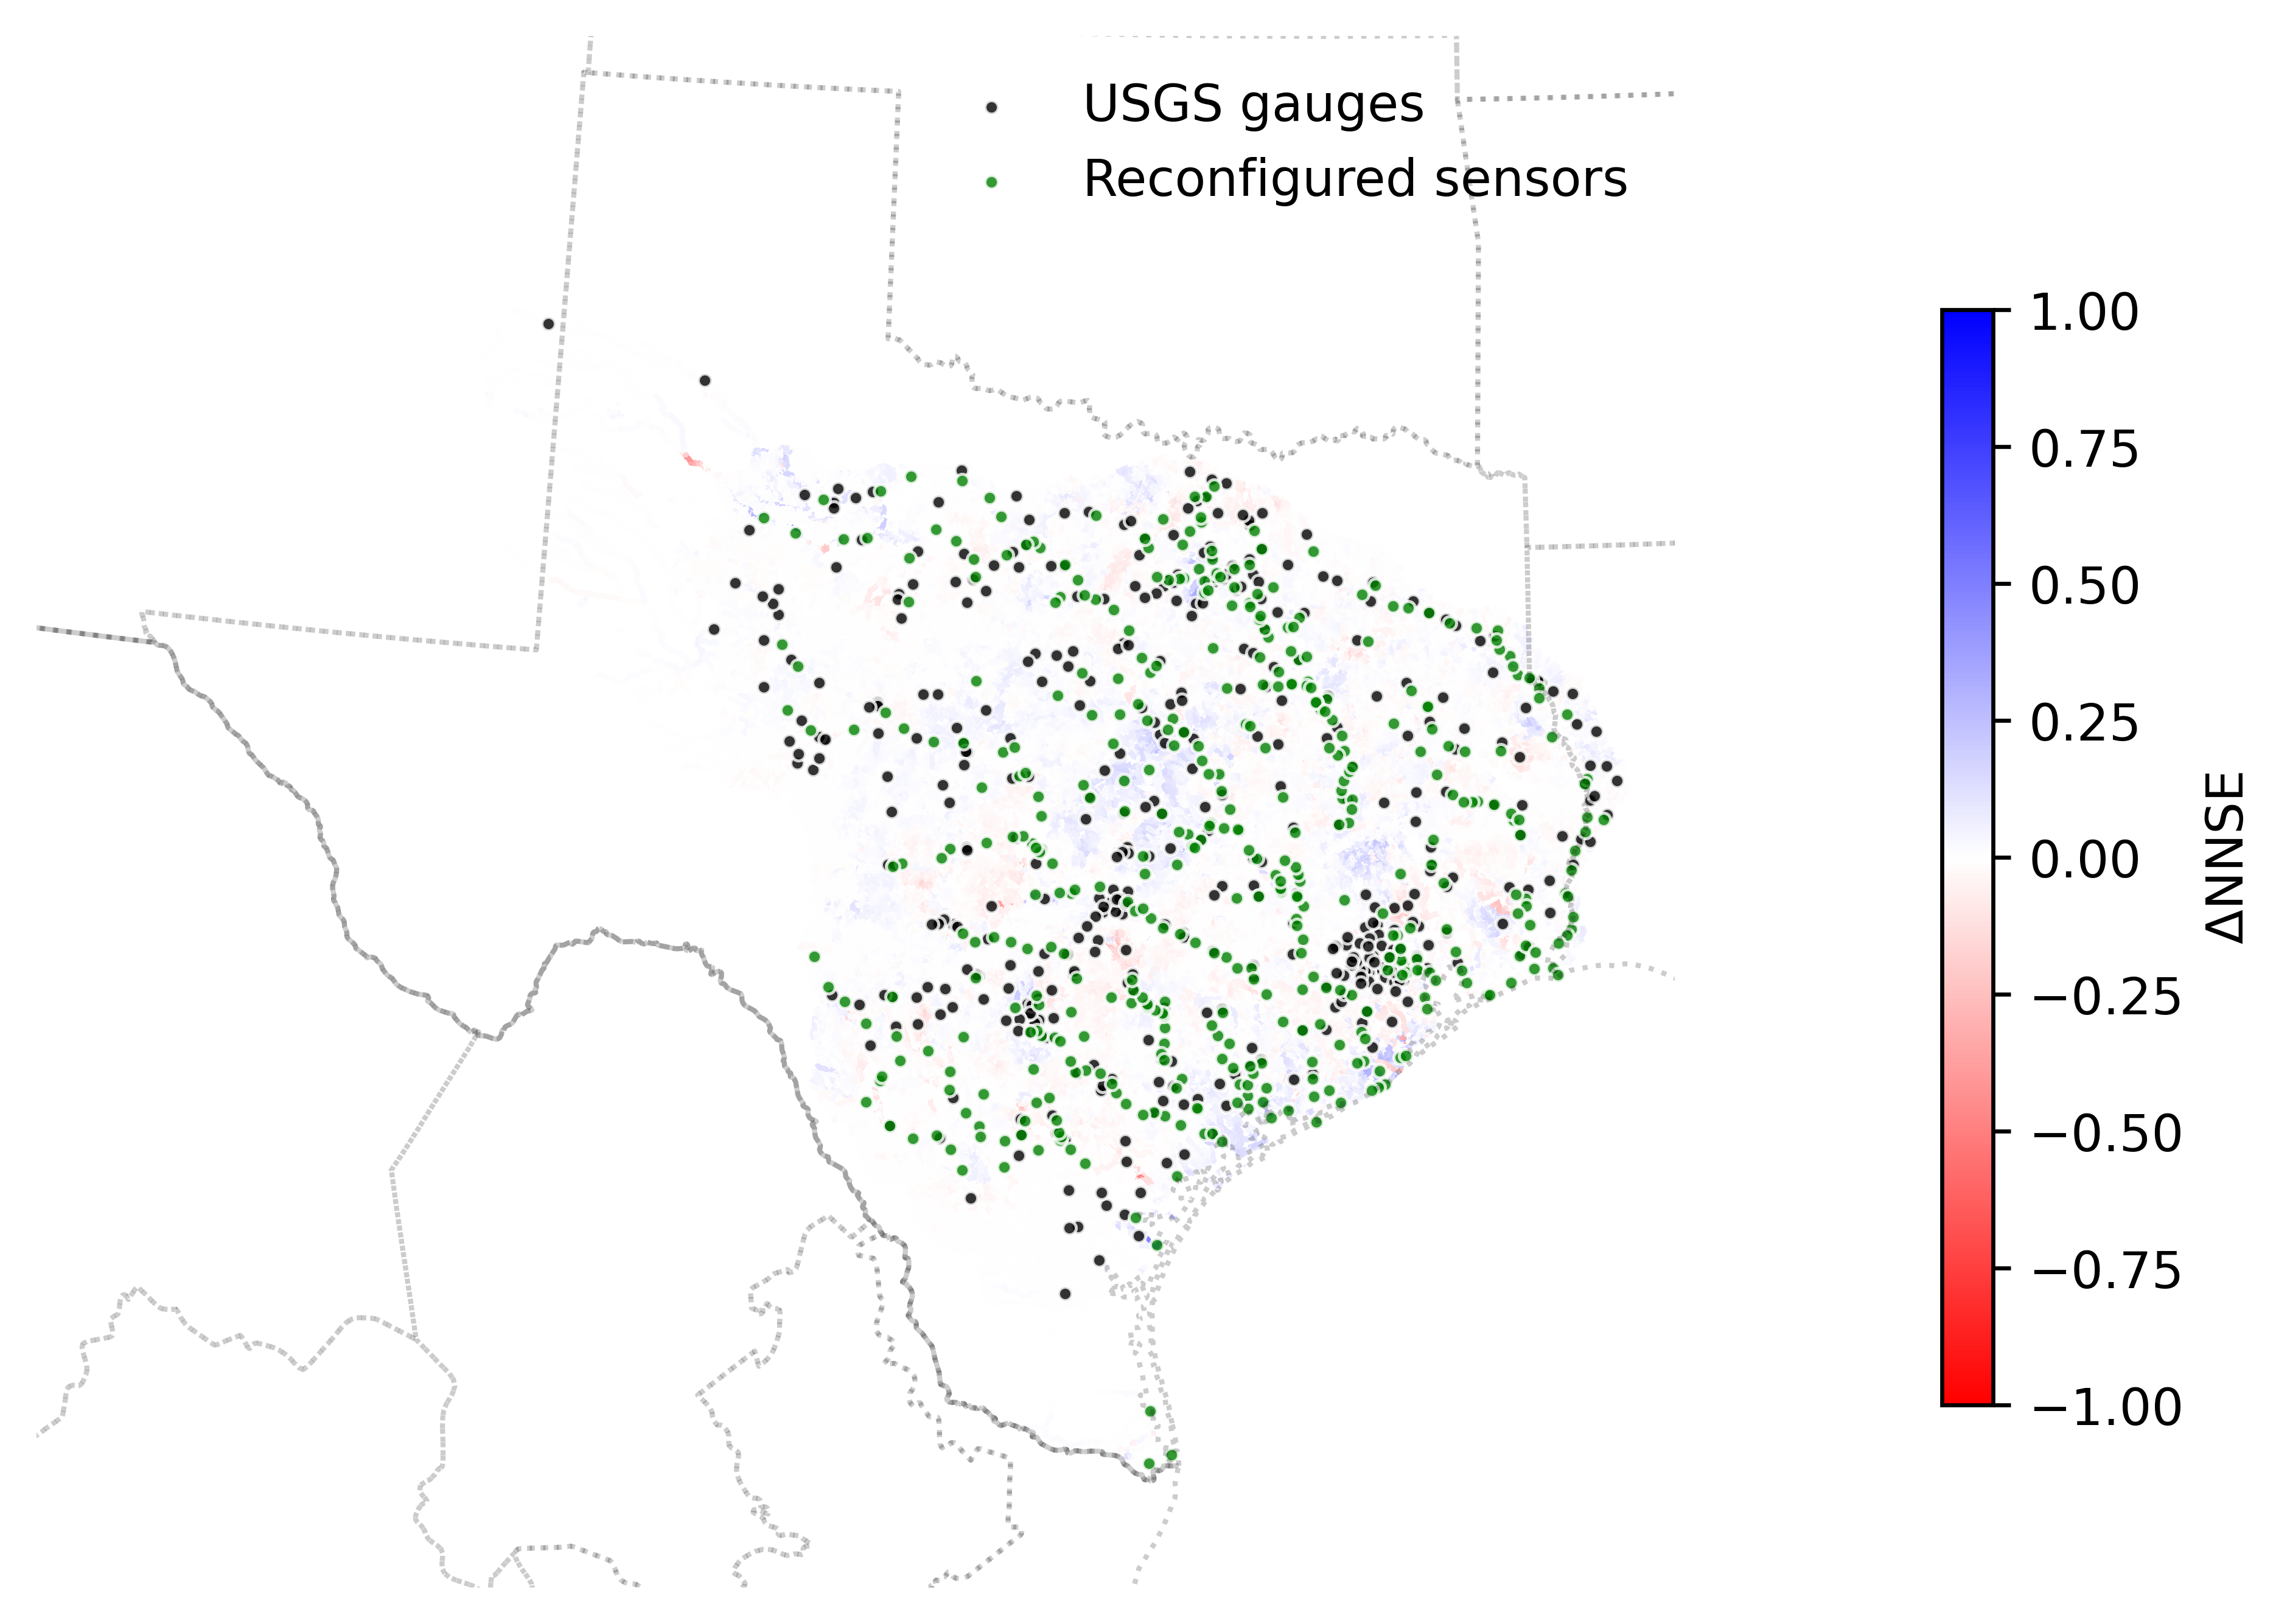

In [9]:
# Visualization

flowlines_with_nnse, centroids = prepare_visualization_data(
    flowlines_gdf, 
    df_cleaned, 
    diff_nnse,
    {'usgs': usgs_location, 'opt': sensor_location},
    usgs_number
)

plot_sensor_network(flowlines_with_nnse, centroids, save_path='sensor_network_risk.png')

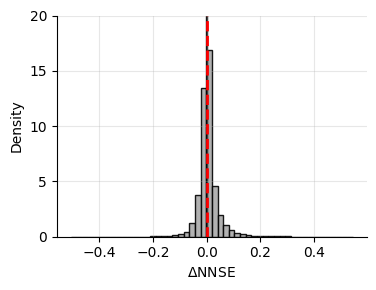

In [10]:
diff_nnse = np.array(diff_nnse)
diff_nnse_cleaned = diff_nnse[~np.isnan(diff_nnse)] 

bin_edges = np.histogram_bin_edges(diff_nnse_cleaned, bins=50)
bin_edges = np.unique(np.concatenate((bin_edges, [0])))

plt.figure(figsize=(4, 3))
plt.hist(diff_nnse_cleaned, bins=bin_edges, alpha=0.9, edgecolor='k', color='darkgrey', density=True)

plt.xlabel(r'$\Delta \mathrm{NNSE}$')#, fontsize=12)
plt.ylabel('Density')#, fontsize=12)

plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)

plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

plt.grid(alpha=0.3)

plt.gca().set_facecolor('none') 
plt.gcf().patch.set_alpha(0)

plt.ylim(0, 20)
plt.tight_layout()
plt.show()

In [11]:
rmse_datasets = [
    ('USGS', rmse_values_usgs),
    ('QR', rmse_values_opt),
    ('QR with Flood Risk', rmse_values_risk)
]
labels, data = zip(*rmse_datasets)

In [12]:
# Normalize cost_index
scaler = MinMaxScaler()
epsilon = 1e-10

cost_index_normalized = scaler.fit_transform(flood_risk.reshape(-1, 1)).flatten()
cost_index_normalized = np.maximum(cost_index_normalized, epsilon)
cost_index = np.maximum(flood_risk, epsilon)

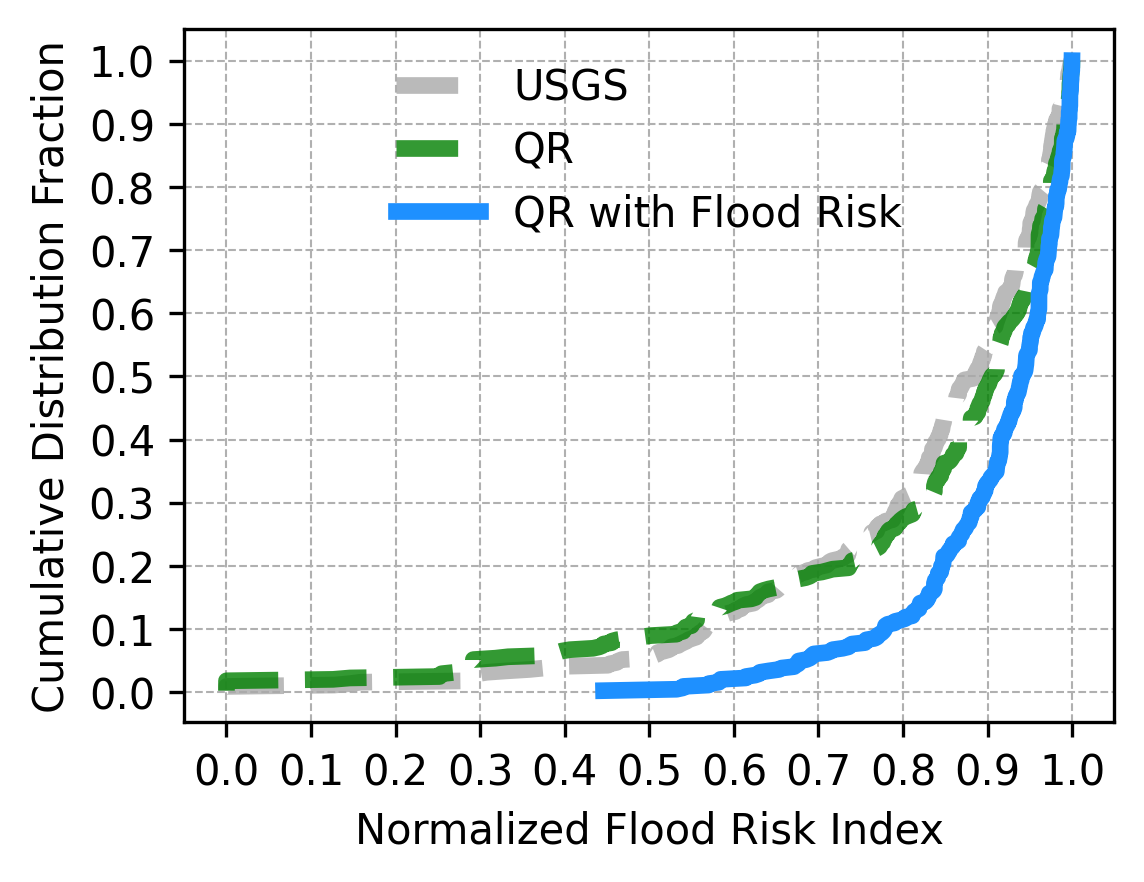

In [13]:
costs = np.sort(cost_index_normalized[sensor_location_risk]).reshape(-1, 1)
costs_usgs = np.sort(cost_index_normalized[usgs_location]).reshape(-1, 1)
costs_raw = np.sort(cost_index_normalized[sensor_location]).reshape(-1, 1)

cumulative = np.arange(1, len(costs) + 1) / len(costs)
cumulative_usgs = np.arange(1, len(costs_usgs)+1) / len(costs_usgs)
cumulative_raw = np.arange(1, len(costs_raw)+1) / len(costs_raw)
colors = ['darkgrey', 'green', 'dodgerblue']

plt.figure(figsize=(4, 3), dpi=300)  
plt.plot(costs_usgs, cumulative_usgs, linestyle='--', color=colors[0], alpha = 0.8, linewidth = 4, label='USGS')
plt.plot(costs_raw, cumulative_raw, linestyle='--', color=colors[1], alpha = 0.8, linewidth = 4, label='QR')
plt.plot(costs, cumulative, linestyle='-', color=colors[2], linewidth = 4, label='QR with Flood Risk')

plt.xlabel('Normalized Flood Risk Index')
plt.ylabel('Cumulative Distribution Fraction')

plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.legend(frameon=False, loc = 'upper center') 
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 
plt.show()

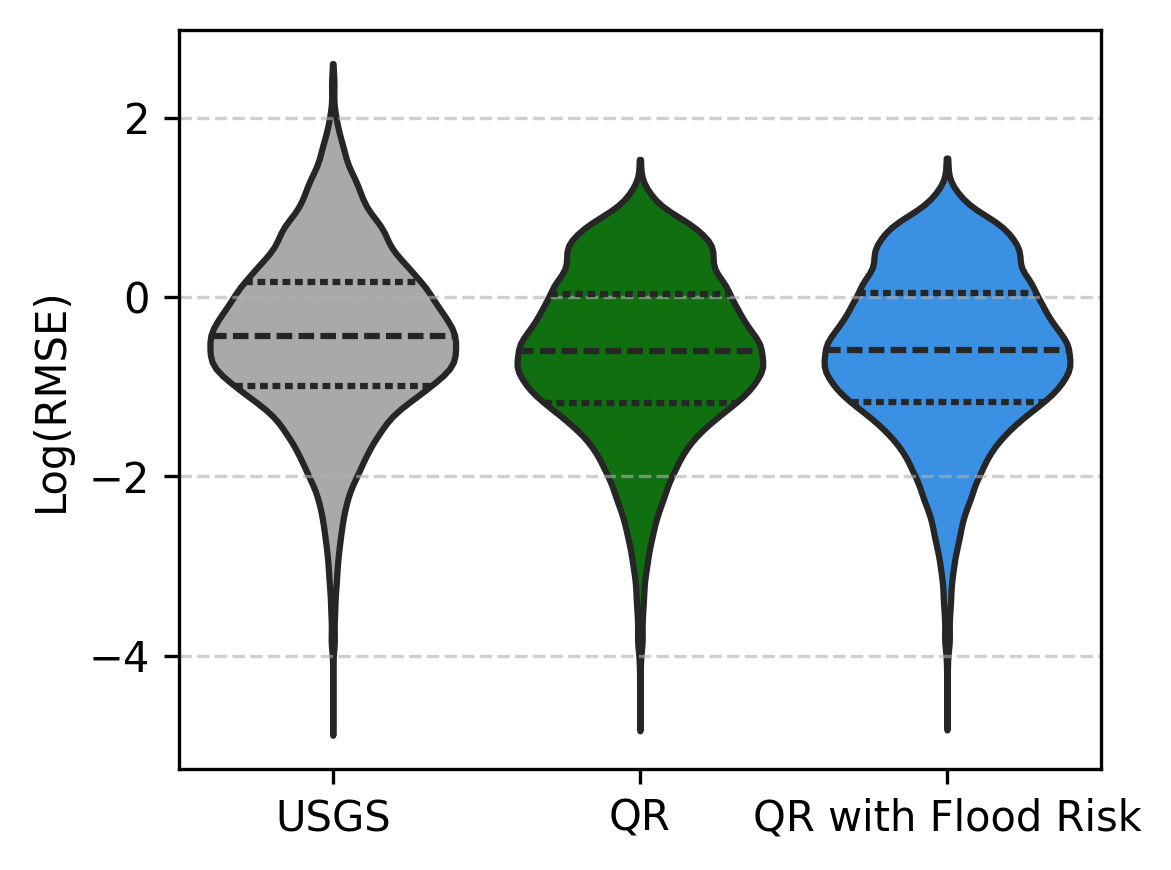

In [14]:
# Filter and log-transform data
filtered_data = [d[(d > 1e-5) & (d < 1e3)] for d in data]
log_data = [np.log10(d) for d in filtered_data]

plt.figure(figsize=(4, 3), dpi=300)
sns.violinplot(
    data=log_data,
    scale='width',   
    inner='quartile',
    linewidth=1.5,
    palette=colors,
    cut=0
)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.ylabel('Log(RMSE)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()